In [2]:
import numpy as np
import scipy as sp
import seaborn as sn
import matplotlib.pylab as pl
%matplotlib inline

import os 
os.chdir('../hedfpy/')

from EDFOperator import EDFOperator
from HDFEyeOperator import HDFEyeOperator
from EyeSignalOperator import EyeSignalOperator

os.chdir(os.path.expanduser('~/Downloads/'))

sn.set(style="ticks")

In [3]:
print(os.getcwd())

/Users/knapen/Downloads


In [4]:
edf_file = 'sub-10_task-dis_col-bl_run-6.edf'

low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01
alias = 'test_1'

# initialize the hdfeyeoperator
ho = HDFEyeOperator(os.path.expanduser('~/Downloads/test.h5'))
# insert the edf file contents only when the h5 is not present.
if not os.path.isfile(os.path.expanduser('~/Downloads/test.h5')):
    ho.add_edf_file(edf_file)
    ho.edf_message_data_to_hdf(alias = alias)
    ho.edf_gaze_data_to_hdf(alias = alias, pupil_hp = high_pass_pupil_f, pupil_lp = low_pass_pupil_f)

19-11-01_11-48-04 - INFO - EDFOperator - started with sub-10_task-dis_col-bl_run-6.edf
19-11-01_11-48-04 - INFO - EDF2ASCOperator - <CommandLineOperator.EDF2ASCOperator object at 0x925342fd0> initialized with file sub-10_task-dis_col-bl_run-6.edf
19-11-01_11-48-04 - DEBUG - EDF2ASCOperator - <CommandLineOperator.EDF2ASCOperator object at 0x925342fd0>executing command 
edf2asc -t -ftime -y -z -v -s -miss 0.0001 -vel "sub-10_task-dis_col-bl_run-6.edf"; mv "sub-10_task-dis_col-bl_run-6.asc" "sub-10_task-dis_col-bl_run-6.gaz"; edf2asc -t -ftime -y -z -v -e "sub-10_task-dis_col-bl_run-6.edf"; mv "sub-10_task-dis_col-bl_run-6.asc" "sub-10_task-dis_col-bl_run-6.msg"
19-11-01_11-48-06 - INFO - EDFOperator - reading trials from sub-10_task-dis_col-bl_run-6.msg
19-11-01_11-48-06 - INFO - EDFOperator - reading key_events from sub-10_task-dis_col-bl_run-6.msg
19-11-01_11-48-07 - INFO - EDFOperator - reading key_events from sub-10_task-dis_col-bl_run-6.msg
19-11-01_11-48-07 - INFO - EDFOperator - r

/Users/knapen/miniconda3/envs/py36/lib/python3.6/site-packages/tables/atom.py:392: FlavorWarning: support for unicode type is very limited, and only works for strings that can be cast as ascii
  "and only works for strings that can be cast as ascii", FlavorWarning)


AttributeError: 'EDFOperator' object has no attribute 'blink_type_dictionary'

In [4]:
# downsample for plotting
downsample_rate = 10

# load times per session:
trial_times = ho.read_session_data(alias, 'trials')
trial_phase_times = ho.read_session_data(alias, 'trial_phases')

# check at what timestamps the recording started:
session_start_EL_time = np.array( trial_phase_times[np.array(trial_phase_times['trial_phase_index'] == 1) * np.array(trial_phase_times['trial_phase_trial'] == 0)]['trial_phase_EL_timestamp'] )[0]
session_stop_EL_time = np.array(trial_times['trial_end_EL_timestamp'])[-1]

# and, find some aspects of the recording such as sample rate and recorded eye
sample_rate = ho.sample_rate_during_period([session_start_EL_time, session_stop_EL_time], alias)
eye = ho.eye_during_period([session_start_EL_time, session_stop_EL_time], alias)
if len(eye) > 0:
    eye = ['L','R'][0]

/Users/knapen/anaconda3/envs/i2.7/lib/python2.7/site-packages/scipy/signal/signaltools.py:3073: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


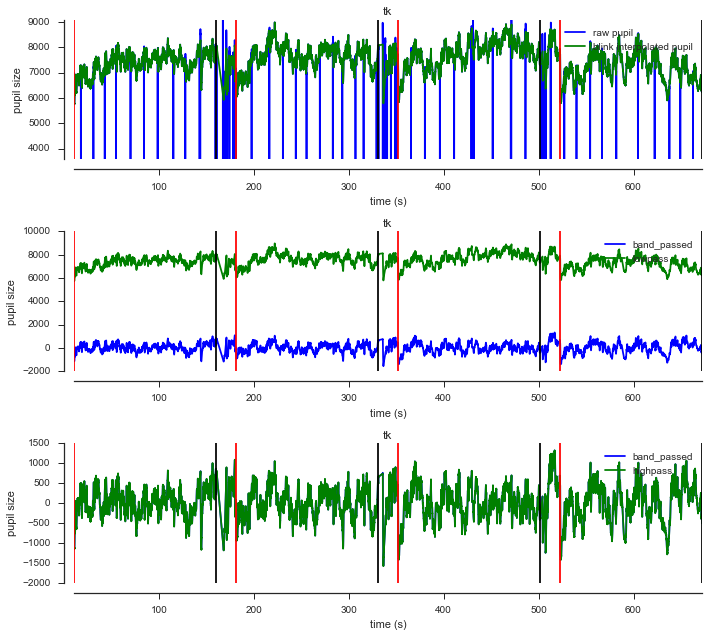

In [5]:
#
# plot some of the pupil signal's processing steps
#

pupil_raw = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil', requested_eye = eye))
pupil_int = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_int', requested_eye = eye))

pupil_bp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_bp', requested_eye = eye))
pupil_lp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_lp', requested_eye = eye))
pupil_hp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_hp', requested_eye = eye))

x = sp.signal.decimate(np.arange(len(pupil_raw)) / float(sample_rate), downsample_rate, 1)
pup_raw_dec = sp.signal.decimate(pupil_raw, downsample_rate, 1)
pup_int_dec = sp.signal.decimate(pupil_int, downsample_rate, 1)

pupil_bp_dec = sp.signal.decimate(pupil_bp, downsample_rate, 1)
pupil_lp_dec = sp.signal.decimate(pupil_lp, downsample_rate, 1)
pupil_hp_dec = sp.signal.decimate(pupil_hp, downsample_rate, 1)

# plot interpolated pupil:
fig = pl.figure(figsize = (10,9))
s = fig.add_subplot(311)
pl.plot(x, pup_raw_dec, 'b'); pl.plot(x, pup_int_dec, 'g')
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['raw pupil', 'blink interpolated pupil'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))
sn.despine(offset=10)

s = fig.add_subplot(312)
pl.plot(x, pupil_bp_dec, 'b'); pl.plot(x, pupil_lp_dec, 'g');
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['band_passed', 'lowpass'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
# s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))
sn.despine(offset=10)

s = fig.add_subplot(313)
pl.plot(x, pupil_bp_dec, 'b'); pl.plot(x, pupil_hp_dec, 'g');
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['band_passed', 'highpass'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
# s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))
sn.despine(offset=10)
pl.tight_layout()


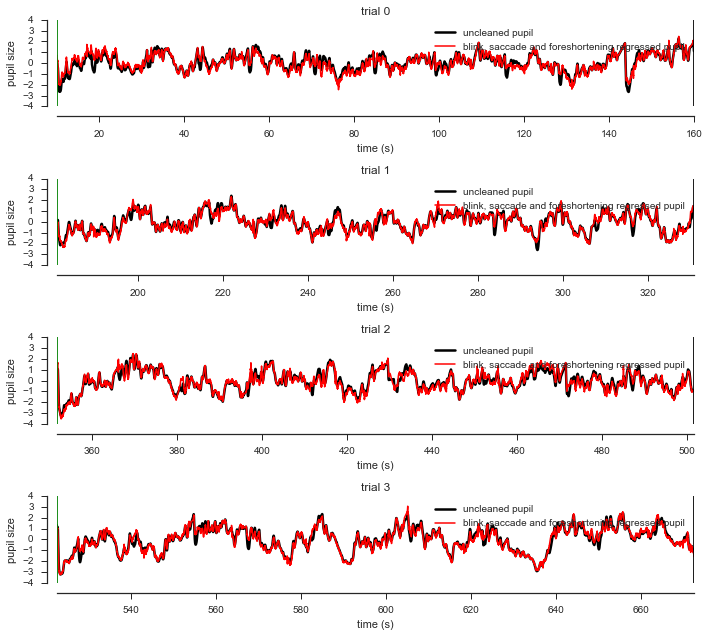

In [6]:
#
# plot the 'regress blinks' processing step, 
# which estimates the effects of blinks, saccades and foreshortening on the data
# and regresses these effects out.
#

pupil_bp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_bp_zscore', requested_eye = eye))
pupil_bp_c = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_bp_clean_zscore', requested_eye = eye))

x = sp.signal.decimate(np.arange(len(pupil_bp)) / float(sample_rate), downsample_rate, 1)
pupil_bp_dec = sp.signal.decimate(pupil_bp, downsample_rate, 1)
pupil_bp_c_dec = sp.signal.decimate(pupil_bp_c, downsample_rate, 1)


# plot interpolated pupil:
fig = pl.figure(figsize = (10,9))
for trial in range(4):# loop across trials
    s = fig.add_subplot(4,1,trial+1)
    s.set_title('trial %i'%trial)
    pl.plot(x, pupil_bp_dec, 'k', lw = 2.5)
    pl.plot(x, pupil_bp_c_dec, 'r', lw = 1.5)
    pl.ylabel('pupil size'); pl.xlabel('time (s)')
    pl.legend(['uncleaned pupil', 'blink, saccade and foreshortening regressed pupil'])

    ymin = pupil_bp.min(); ymax = pupil_bp.max()
    tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
    for i in range(tps[0].shape[0]):
        pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'g')
        pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
    # s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
    s.set_xlim(xmin = tps[0][trial] / float(sample_rate), xmax = tps[-1][trial] / float(sample_rate))
    sn.despine(offset=10)
pl.tight_layout()

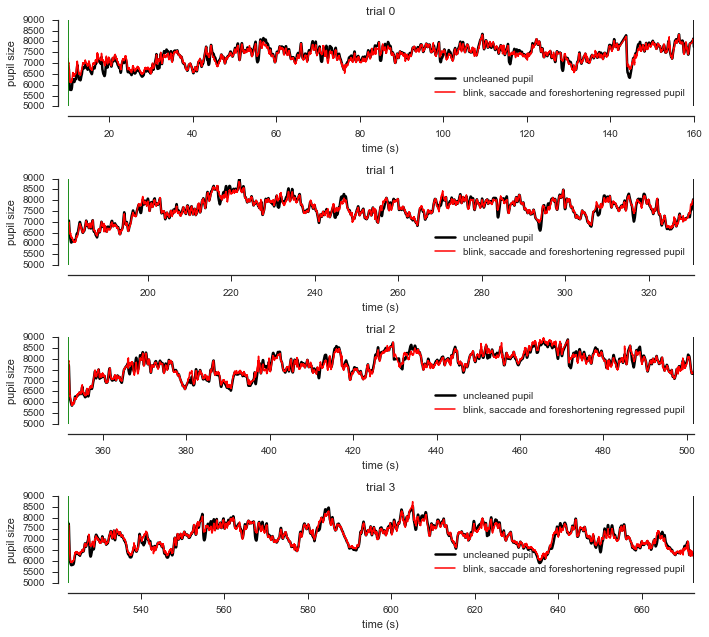

In [7]:
#
# plot the 'regress blinks' processing step, 
# which estimates the effects of blinks, saccades and foreshortening on the data
# and regresses these effects out.
#

pupil_lp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_lp', requested_eye = eye))
pupil_lp_c = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_lp_clean', requested_eye = eye))

x = sp.signal.decimate(np.arange(len(pupil_lp)) / float(sample_rate), downsample_rate, 1)
pupil_lp_dec = sp.signal.decimate(pupil_lp, downsample_rate, 1)
pupil_lp_c_dec = sp.signal.decimate(pupil_lp_c, downsample_rate, 1)


# plot interpolated pupil:
fig = pl.figure(figsize = (10,9))
for trial in range(4):# loop across trials
    s = fig.add_subplot(4,1,trial+1)
    s.set_title('trial %i'%trial)
    pl.plot(x, pupil_lp_dec, 'k', lw = 2.5)
    pl.plot(x, pupil_lp_c_dec, 'r', lw = 1.5)
    pl.ylabel('pupil size'); pl.xlabel('time (s)')
    pl.legend(['uncleaned pupil', 'blink, saccade and foreshortening regressed pupil'], loc= 4)

    ymin = pupil_bp.min(); ymax = pupil_bp.max()
    tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
    for i in range(tps[0].shape[0]):
        pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'g')
        pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
    s.set_ylim(ymin = 5000, ymax = 9000)
    s.set_xlim(xmin = tps[0][trial] / float(sample_rate), xmax = tps[-1][trial] / float(sample_rate))
    sn.despine(offset=10)
pl.tight_layout()